In [1]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

sns.set(font_scale=1.5, palette='Set2')
warnings.filterwarnings("ignore")

## Задача 6.2

Реализация MAPE

In [2]:
def mape(y_true, y_pred):
    return 100 * np.abs((y_true - y_pred) / y_true).mean()

Считываем данные

In [3]:
train_df = pd.read_csv('houses_train.csv').drop(columns=['id', 'date'])
train_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
3,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
4,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819


Посмотрим на их описания

In [4]:
train_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.562600e+04,15626.000000,15626.000000,15626.000000,1.562600e+04,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000
mean,5.355339e+05,3.371240,2.111737,2073.132919,1.506655e+04,1.494304,0.007488,0.228465,3.408870,7.649878,1785.817868,287.315052,1970.937028,86.066684,98077.961858,47.559655,-122.213479,1980.853897,12689.631384
std,3.595051e+05,0.909872,0.769037,911.406092,4.235533e+04,0.539333,0.086209,0.757528,0.651925,1.171214,821.668484,439.948411,29.368239,405.398690,53.598316,0.138845,0.141089,680.403268,27103.989191
min,7.500000e+04,0.000000,0.000000,290.000000,6.000000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.200000e+05,3.000000,1.500000,1430.000000,5.060000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.470225,-122.328000,1480.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.598500e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,1830.000000,7620.000000
75%,6.400000e+05,4.000000,2.500000,2540.000000,1.057975e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1996.750000,0.000000,98118.000000,47.678200,-122.124000,2360.000000,10027.000000
max,7.700000e+06,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,871200.000000


In [5]:
train_df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

Внимательно изучив признаки понимаем, что единственным категориальным признаком можно считать почтовый индекс `zipcode`

In [6]:
cat_features = ['zipcode']

Уникальные значения этого признака

In [7]:
train_df['zipcode'].unique()

array([98178, 98125, 98136, 98074, 98003, 98198, 98146, 98038, 98007,
       98115, 98028, 98126, 98019, 98103, 98002, 98133, 98040, 98092,
       98030, 98119, 98112, 98052, 98027, 98117, 98058, 98001, 98056,
       98053, 98148, 98105, 98042, 98008, 98059, 98166, 98122, 98004,
       98005, 98116, 98023, 98199, 98032, 98045, 98102, 98077, 98168,
       98065, 98107, 98006, 98109, 98022, 98034, 98075, 98033, 98144,
       98177, 98155, 98108, 98118, 98011, 98024, 98010, 98106, 98070,
       98031, 98072, 98014, 98055, 98029, 98188, 98039])

Отобразим почтовый индекс на карте города, используя значения широты и долготы. Видим, что объекты разбиваются по райоам города

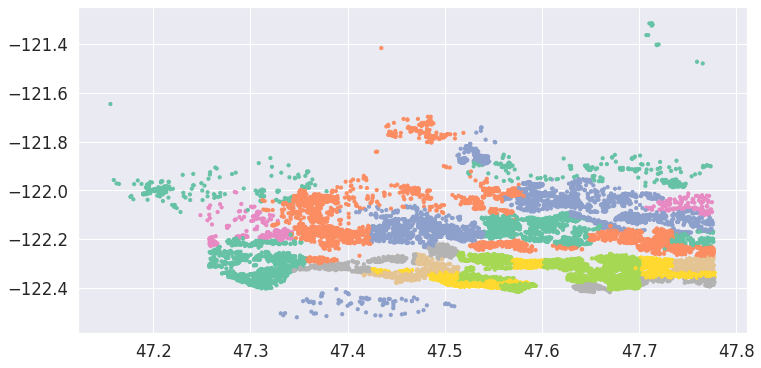

In [8]:
plt.figure(figsize=(12, 6))
plt.scatter(train_df['lat'], train_df['long'], 
            c=train_df['zipcode'], cmap='Set2', s=10);

Разобьем данные на обучающую и валидационную выборки. На первой будем обучать все модели, на второй -- проверять качество моделей

In [9]:
X, labels = train_df.drop(columns=['price']), train_df['price']
x_train, x_valid, y_train, y_valid = train_test_split(X, labels, 
                                                      test_size=0.3)

Для кодировки категориальных признаков будем использовать `MeanEncoder`, который заменяет значение категории на среднее значение таргета в этой категории. Если категория не встречалась в трейне, то на глобальное среднее таргета.

In [10]:
# https://github.com/AndreyKoceruba/mean-encoding/blob/master/mean_encoder.py

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

class MeanEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, target_type='binary', 
                 encoding='likelihood', func=None):
        if target_type == 'continuous' and encoding in ['woe', 'diff']:
            raise ValueError(
                '{} target_type can\'t be used with {} encoding'.format(target_type, encoding)
            )
        self.target_type = target_type
        self.encoding = encoding
        self.func = func
    
    def goods(self, x):
        return np.sum(x == 1)
    
    def bads(self, x):
        return np.sum(x == 0)
    
    def encode(self, X, y, agg_func):
        self.means = dict()
        self.global_mean = np.nan
        X['target'] = y
        for col in X.columns:
            if col != 'target':
                col_means = X.groupby(col)['target'].agg(agg_func)
                self.means[col] = col_means
        X.drop(['target'], axis=1, inplace = True)
        
    def fit(self, X, y):
        if self.encoding == 'woe':
            self.encode(X, y, lambda x: np.log(self.goods(x) / self.bads(x)) * 100)
            self.global_mean = np.log(self.goods(y) / self.bads(y)) * 100
        elif self.encoding == 'diff':
            self.encode(X, y, lambda x: self.goods(x) - self.bads(x))
            self.global_mean = self.goods(y) - self.bads(y)
        elif self.encoding == 'likelihood':
            self.encode(X, y, np.mean)
            self.global_mean = np.mean(y)
        elif self.encoding == 'count':
            self.encode(X, y, np.sum)
            self.global_mean = np.sum(y)
        elif self.encoding == 'function':
            self.encode(X, y, lambda x: self.func(x))
            self.global_mean = self.func(y)
        return self
    
    def transform(self, X):
        X_new = pd.DataFrame()
        for col in X.columns:
            X_new[col] = X[col].map(self.means[col]).fillna(self.global_mean)
        return X_new
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

Сохраним оригинальные данные

In [11]:
x_train_origin = x_train.copy()
x_valid_origin = x_valid.copy()

Закодируем категориальный признак

In [12]:
encoder = MeanEncoder()
x_train[cat_features] = encoder.fit_transform(x_train[cat_features], y_train)
x_valid[cat_features] = encoder.transform(x_valid[cat_features])

Некоторая вспомогательная функция для отрисовки графиков

In [14]:
colors = ['#FF3300', '#0099CC', '#00CC66', 'orange']

def plot_dependence_test(param_grid, mape_train, mape_valid, descr,
                         param_label,
                         title, ylim=(11, 16)):
    '''
    Функция для построения графиков зависимости целевой метрики 
    от некоторого параметра моделей на обучающей и валидационной выборках.
    
    Параметры.
    1) param_grid - значения исследуемого параметра,
    2) mape_train - значения метрик на обучающей выборке,
    3) mape_train - значения метрик на валидационной выборке,
    4) descr - описания моделей для легенды
    5) param_label - названия параметра,
    6) title - заголовок для графика.
    '''
    
    plt.figure(figsize=(16, 8))
    
    for i in range(len(mape_train)):
        plt.plot(param_grid, mape_train[i], color=colors[i], 
                 linewidth=2, linestyle='--', alpha=0.7,
                label=descr[i]+' train')
        plt.plot(param_grid, mape_valid[i], color=colors[i], 
                 linewidth=4, alpha=0.7, label=descr[i]+' valid')
   
    plt.xlabel(param_label)
    plt.ylabel('MAPE, %')
    plt.legend(ncol=2)
    plt.title(title)
    plt.ylim(ylim)
    plt.show()

## 1. Зависимость от количества деревьев

Для каждой модели используем функции получения предсказания с ограничением количества деревьев при предсказаний. Это позволяет не обучать каждый раз одни и те же модели.

In [13]:
n_estimators_grid = np.arange(1, 1000)

regressor = GradientBoostingRegressor(n_estimators=max(n_estimators_grid))
regressor.fit(x_train, y_train)
mape_train = [[mape(y_train, prediction) 
               for prediction in regressor.staged_predict(x_train)]]
mape_valid = [[mape(y_valid, prediction) for 
               prediction in regressor.staged_predict(x_valid)]]

regressor = XGBRegressor(n_estimators=max(n_estimators_grid))
regressor.fit(x_train, y_train)
mape_train += [[mape(y_train, regressor.predict(x_train, ntree_limit=i+1))
                for i in range(max(n_estimators_grid))]]
mape_valid += [[mape(y_valid, regressor.predict(x_valid, ntree_limit=i+1))
                for i in range(max(n_estimators_grid))]]

regressor = LGBMRegressor(n_estimators=max(n_estimators_grid))
regressor.fit(x_train_origin, y_train, categorical_feature=cat_features)
mape_train += [[mape(y_train, regressor.predict(x_train_origin, 
                                                num_iteration=i+1))
                for i in range(max(n_estimators_grid))]]
mape_valid += [[mape(y_valid, regressor.predict(x_valid_origin, 
                                                num_iteration=i+1))
                for i in range(max(n_estimators_grid))]]

regressor = CatBoostRegressor(n_estimators=max(n_estimators_grid), 
                              cat_features=cat_features, verbose=0)
regressor.fit(x_train_origin, y_train)
mape_train += [[mape(y_train, regressor.predict(x_train_origin, ntree_end=i+1))
                for i in range(max(n_estimators_grid))]]
mape_valid += [[mape(y_valid, regressor.predict(x_valid_origin, ntree_end=i+1))
                for i in range(max(n_estimators_grid))]]

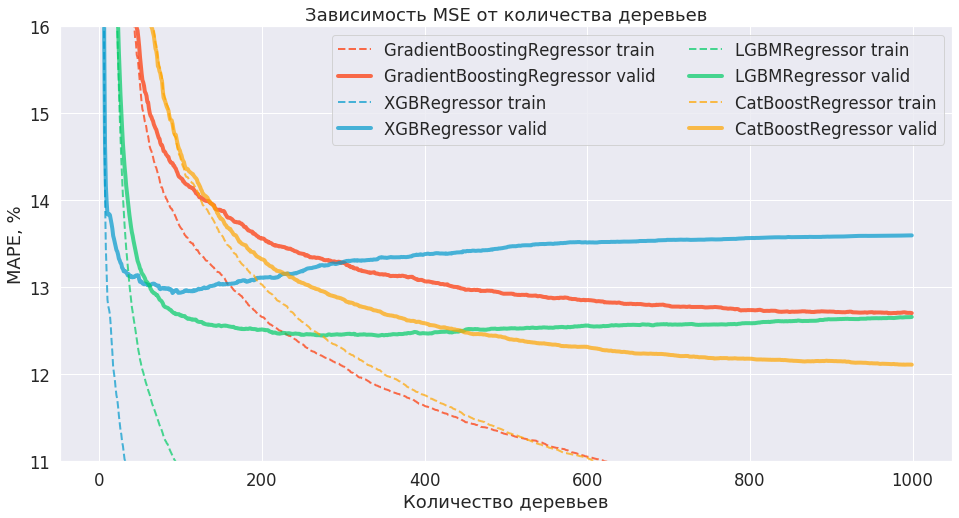

In [15]:
plot_dependence_test(n_estimators_grid, mape_train, mape_valid,
                     ['GradientBoostingRegressor', 'XGBRegressor', 
                      'LGBMRegressor', 'CatBoostRegressor'],
                     'Количество деревьев', 
                     'Зависимость MSE от количества деревьев')

**Вывод:** XGBoost и LightGBM позволяют быстро получить довольно приемлимое качество на небольшом количестве деревьев. Однако при увеличении количества деревьев они начинают переобучаться. CatBoost'у требуется большое количество деревьев для получения хорошего качества, причем при увеличении количества деревьев не наблюдается переобучения. Подобные свойства наблюдаются у реализации из sklearn. Наилучшее качество на валидационной выборке позволяет получить CatBoost.

## 2. Зависимость от максимальной глубины дерева

In [16]:
max_depth_grid = np.arange(2, 12)

mape_train, mape_valid = np.zeros((2, 4, len(max_depth_grid)))

for i, max_depth in enumerate(max_depth_grid):
    regressor = GradientBoostingRegressor(max_depth=max_depth)
    regressor.fit(x_train, y_train)
    mape_train[0, i] = mape(y_train, regressor.predict(x_train))
    mape_valid[0, i] = mape(y_valid, regressor.predict(x_valid))
    
    regressor = XGBRegressor(max_depth=max_depth)
    regressor.fit(x_train, y_train)
    mape_train[1, i] = mape(y_train, regressor.predict(x_train))
    mape_valid[1, i] = mape(y_valid, regressor.predict(x_valid))
    
    regressor = LGBMRegressor(max_depth=max_depth)
    regressor.fit(x_train_origin, y_train, categorical_feature=cat_features)
    mape_train[2, i] = mape(y_train, regressor.predict(x_train_origin))
    mape_valid[2, i] = mape(y_valid, regressor.predict(x_valid_origin))

    regressor = CatBoostRegressor(max_depth=max_depth, 
                                  cat_features=cat_features, verbose=0)
    regressor.fit(x_train_origin, y_train)
    mape_train[3, i] = mape(y_train, regressor.predict(x_train_origin))
    mape_valid[3, i] = mape(y_valid, regressor.predict(x_valid_origin))

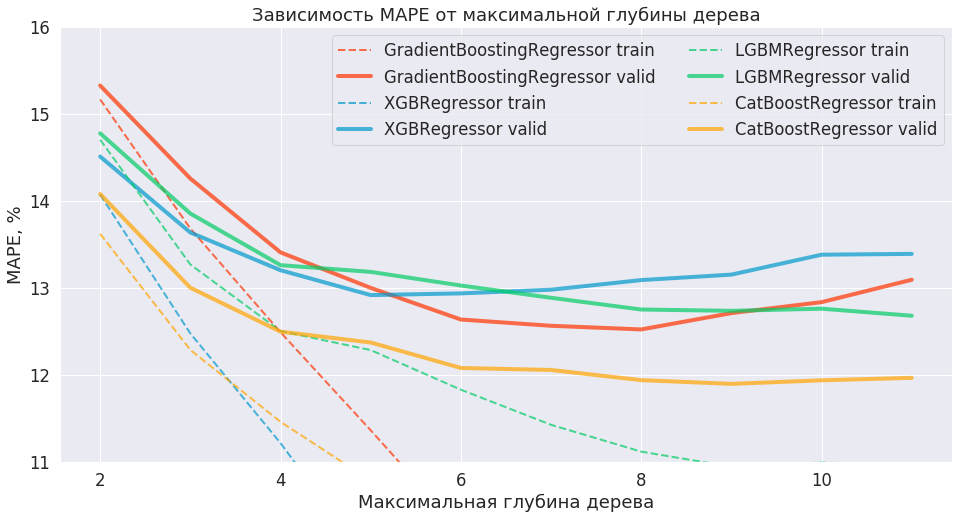

In [17]:
plot_dependence_test(max_depth_grid, mape_train, mape_valid,
                     ['GradientBoostingRegressor', 'XGBRegressor', 
                      'LGBMRegressor', 'CatBoostRegressor'],
                     'Максимальная глубина дерева', 
                     'Зависимость MAPE от максимальной глубины дерева')

**Вывод:** Оптимальная глубина дерева для разных моделей равна от 5 до 8. Модели XGBoost и sklearn-реализация начинают переобучаться с увеличением глубины дерева. Модели LightGBM и CatBoost ведут себя более устойчиво.

## 3. Зависимость от `learning_rate`

In [18]:
learning_rate_grid = np.linspace(0.0125, 0.6, 48)
n_estimators = 100

mape_train, mape_valid = np.zeros((2, 4, len(learning_rate_grid)))

for i, learning_rate in enumerate(learning_rate_grid):
    regressor = GradientBoostingRegressor(learning_rate=learning_rate)
    regressor.fit(x_train, y_train)
    mape_train[0, i] = mape(y_train, regressor.predict(x_train))
    mape_valid[0, i] = mape(y_valid, regressor.predict(x_valid))
    
    regressor = XGBRegressor(learning_rate=learning_rate)
    regressor.fit(x_train, y_train)
    mape_train[1, i] = mape(y_train, regressor.predict(x_train))
    mape_valid[1, i] = mape(y_valid, regressor.predict(x_valid))
    
    regressor = LGBMRegressor(learning_rate=learning_rate)
    regressor.fit(x_train_origin, y_train, categorical_feature=cat_features)
    mape_train[2, i] = mape(y_train, regressor.predict(x_train_origin))
    mape_valid[2, i] = mape(y_valid, regressor.predict(x_valid_origin))

    regressor = CatBoostRegressor(learning_rate=learning_rate, 
                                  cat_features=cat_features, verbose=0)
    regressor.fit(x_train_origin, y_train)
    mape_train[3, i] = mape(y_train, regressor.predict(x_train_origin))
    mape_valid[3, i] = mape(y_valid, regressor.predict(x_valid_origin))

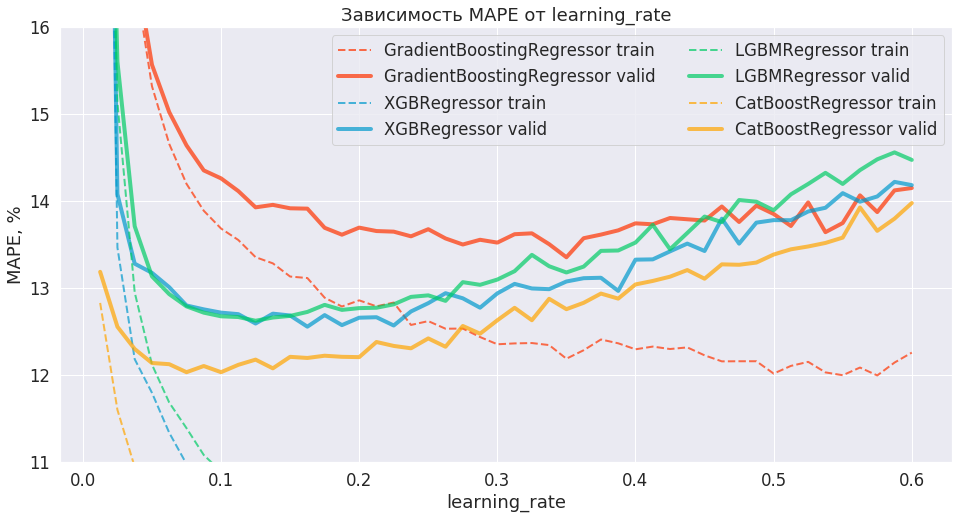

In [19]:
plot_dependence_test(learning_rate_grid, mape_train, mape_valid,
                     ['GradientBoostingRegressor', 'XGBRegressor', 
                      'LGBMRegressor', 'CatBoostRegressor'],
                     'learning_rate', 
                     'Зависимость MAPE от learning_rate')

**Вывод:** Для каждой модели наблюдается некоторое оптимальное значение `learning_rate`. При меньших значениях модели недообучаются, при больших значениях наблюдается неустойчивость моделей при обучении --- графики начинает колбасить. Модель CatBoost показывает наилучшее качество. CatBoost лучший :)